<a href="https://colab.research.google.com/github/4d5645/DeepLearningSchool/blob/main/Dense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning School MIPT


## Homework. Fully Connected and Convolutional Neural Networks

In this activity, we will practice connecting neural networks using the Pytorch library. We will do this on several datasets.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Moons dataset

Let's generate a dataset and take a look at it!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

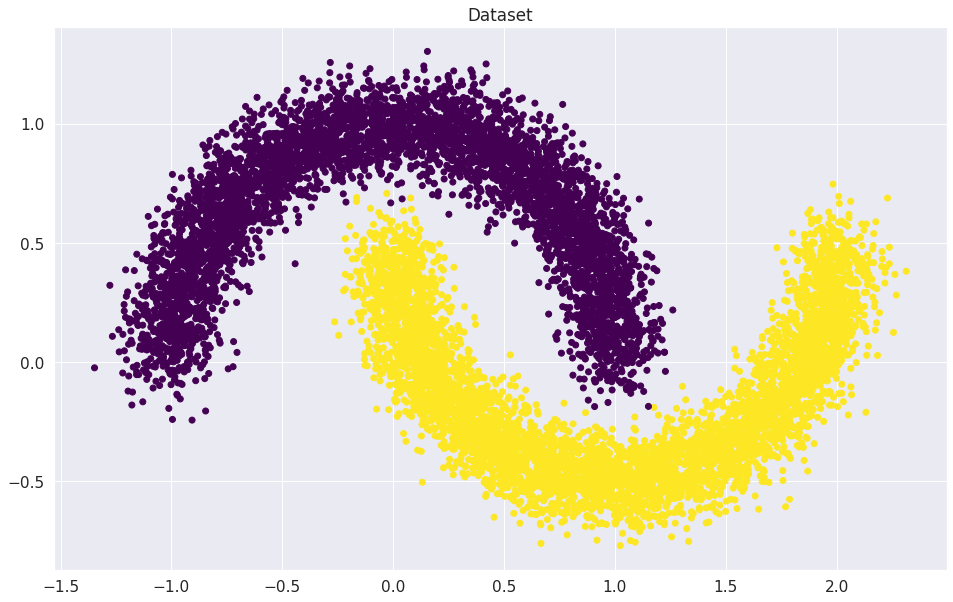

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()


Let's do a train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Loading data
In PyTorch, data loading usually occurs on the fly (sometimes datasets do not fit into RAM). For this, two entities `Dataset` and `DataLoader` are used.

1.   `Dataset` loads each object individually.

2.   `DataLoader` groups objects from `Dataset` into batches.

Since our dataset is quite small we will use `TensorDataset`. All we need is to convert from a numpy array to a tensor with type `torch.float32`.


### Let's create tensors with training and test data

In [5]:
X_train_t =  torch.from_numpy(X_train)
y_train_t =  torch.from_numpy(y_train)
X_val_t = torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Reminder**

Let's take a look at what happens in logistic regression. At the input, we have a matrix object-feature X and a column-vector $y$ – labels from $\{0, 1\}$ for each object. 
We want to find such a weight matrix $W$ and $b$ (bias), that our model $XW + b$ will somehow predict the class of the object.
As you can see at the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is commonly referred to as "logits". We need to translate it to the interval $[0;1]$ 
in order for it to give us the probability that an object belongs to class one, it is also better that this function be monotonic, quickly calculated, have a derivative and on $-\infty$ it had the value $0$, and on $+\infty$ it had the value $1$. Such a class of functions is called a sigmoid. Most often, as a sigmoid, we will take
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Logistic regression implementation
Let's write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are parameters (`nn.Parameter`) of the model. In other words, here we implement the `nn.Linear` module with our own hands (at this point, its use is prohibited). We initialize the weights with a normal distribution (`torch.randn`).


In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features, dtype=torch.double))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(out_features, requires_grad=True, dtype=torch.double))


    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [9]:
print(list(linear_regression.parameters()))

[Parameter containing:
tensor([[ 0.4359],
        [-0.4090]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([1.], dtype=torch.float64, requires_grad=True)]


### Train loop

Here is pseudo code to help us understand what happens during training

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```


The code below adds `accuracy` and `loss` logging.

### Exercise. Implementation of the learning cycle



In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        y_batch_shape = y_batch.shape
        loss = loss_function(torch.sigmoid(outp), y_batch.to(torch.double).view(y_batch_shape[0], 1))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.7109375
Iteration: 200
Batch accuracy: 0.8203125
Iteration: 300
Batch accuracy: 0.8671875
Iteration: 400
Batch accuracy: 0.8671875
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.796875

Iteration: 738.Convergence. Stopping iterations.


### Visualizing the results


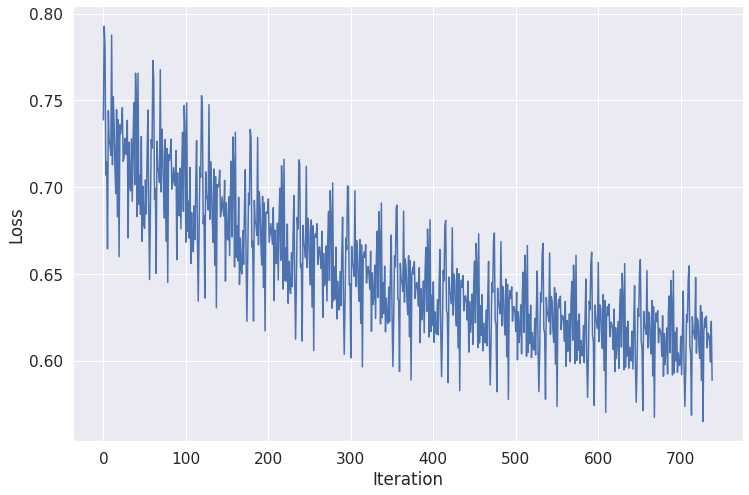

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

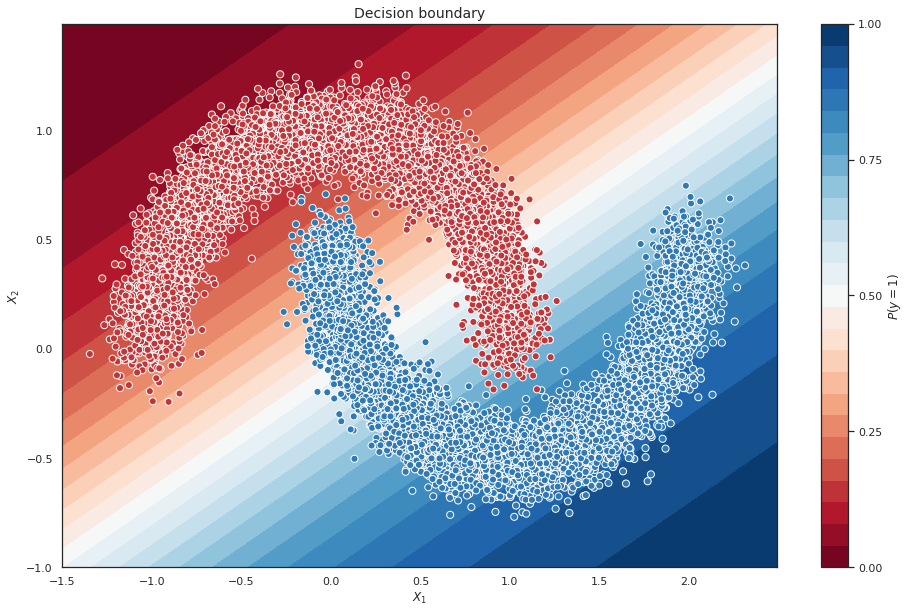

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Exercise. Implement predict and calculate accuracy on test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)
accuracy_score(preds, y_val_t)

0.8572

# Part 2. MNIST Dataset
The MNIST dataset contains handwritten numbers. Let's load the dataset and create DataLoaders. An example can be found in the Seminar on Fully Connected Neural Networks.

In [15]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader =  DataLoader(train_dataset, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Part 2.1. Fully Connected Neural Networks
We first solve MNIST using a fully connected neural network.

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Exercise. Simple fully connected neural network

Create a fully connected neural network using the Sequential class. The network consists of:
* Flattening a matrix into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn.ELU activation;
* Output layer with 10 neurons.

Set the training loss (cross-entropy).


In [17]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Let's figure out the code below, which will work for 90% of tasks in the future.

```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```


### Exercise. Complete the learning cycle.

In [20]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              optimizer.zero_grad()
              model.train()
              outp = model(x_batch)                   
            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all =  preds.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8915833333333333
Loader: valid. Accuracy: 0.9334666666666667
Epoch: 2
Loader: train. Accuracy: 0.9492
Loader: valid. Accuracy: 0.9630333333333333
Epoch: 3
Loader: train. Accuracy: 0.9627166666666667
Loader: valid. Accuracy: 0.97105
Epoch: 4
Loader: train. Accuracy: 0.9711666666666666
Loader: valid. Accuracy: 0.9759666666666666
Epoch: 5
Loader: train. Accuracy: 0.9747666666666667
Loader: valid. Accuracy: 0.9812333333333333
Epoch: 6
Loader: train. Accuracy: 0.9779
Loader: valid. Accuracy: 0.9856166666666667
Epoch: 7
Loader: train. Accuracy: 0.9811
Loader: valid. Accuracy: 0.9844
Epoch: 8
Loader: train. Accuracy: 0.98305
Loader: valid. Accuracy: 0.9814166666666667
Epoch: 9
Loader: train. Accuracy: 0.9851833333333333
Loader: valid. Accuracy: 0.9886666666666667
Epoch: 10
Loader: train. Accuracy: 0.98705
Loader: valid. Accuracy: 0.9904



### Exercise. Test different activation functions.
Try different activation functions. For each activation function, count the validation accuracy array. It is better to implement this as a function that takes an activation as input and receives an array of accuracies.

In [21]:
elu_accuracy = accuracy["valid"]

In [27]:
def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 5
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            for x_batch, y_batch in dataloader:
                epoch_correct = 0
                epoch_all = 0

                x_batch.to(device)
                y_batch.to(device)

                if k == "train":
                    optimizer.zero_grad()
                    model.train()
                    outp = model(x_batch)                
                else:         
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all =  preds.shape[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [28]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
elu_accuracy = test_activation_function(nn.ELU)

Epoch: 1
Loader: train. Accuracy: 0.8854166666666666
Loader: valid. Accuracy: 0.875
Epoch: 2
Loader: train. Accuracy: 0.8958333333333334
Loader: valid. Accuracy: 0.875
Epoch: 3
Loader: train. Accuracy: 0.9166666666666666
Loader: valid. Accuracy: 0.875
Epoch: 4
Loader: train. Accuracy: 0.9270833333333334
Loader: valid. Accuracy: 0.8958333333333334
Epoch: 5
Loader: train. Accuracy: 0.8958333333333334
Loader: valid. Accuracy: 0.9166666666666666
Epoch: 1
Loader: train. Accuracy: 0.9166666666666666
Loader: valid. Accuracy: 0.9375
Epoch: 2
Loader: train. Accuracy: 0.96875
Loader: valid. Accuracy: 0.96875
Epoch: 3
Loader: train. Accuracy: 0.96875
Loader: valid. Accuracy: 0.96875
Epoch: 4
Loader: train. Accuracy: 0.96875
Loader: valid. Accuracy: 0.96875
Epoch: 5
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 0.9583333333333334
Epoch: 1
Loader: train. Accuracy: 0.8958333333333334
Loader: valid. Accuracy: 0.875
Epoch: 2
Loader: train. Accuracy: 0.9583333333333334
Loader: va


### Accuracy
Let's build an accuracy/epoch graph for each activation function.

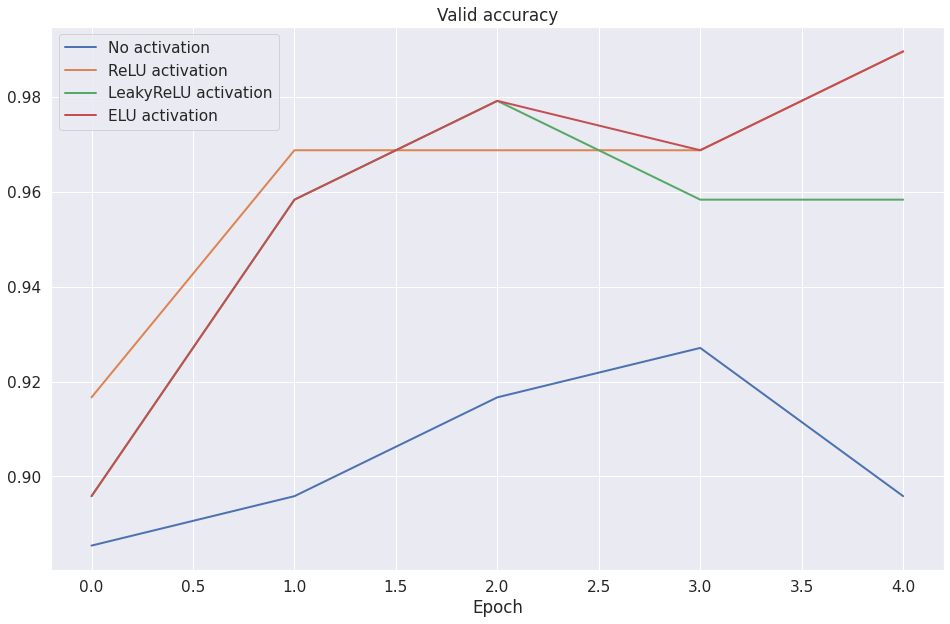

In [30]:
max_epochs = 5
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy['train'], label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy['train'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['train'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['train'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

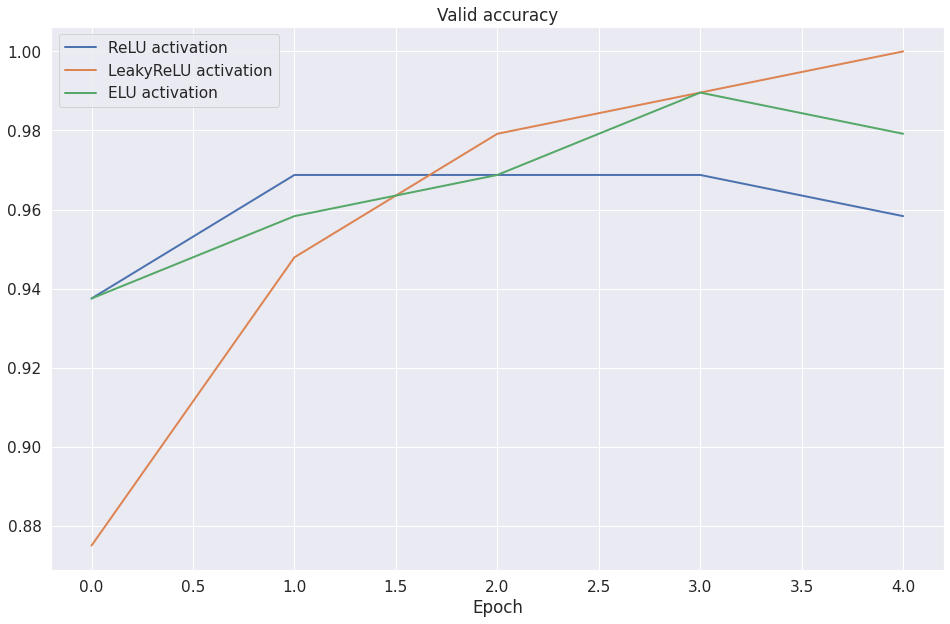

In [32]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Part 2.2 Convolutional Neural Networks


### Kernels
First, let's work a little with the very concept of the convolution kernel.

In [33]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-04-13 13:20:19--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-04-13 13:20:20--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  92.8KB/s    in 0.5s    

2022-04-13 13:20:22 (92.8 KB/s) - ‘sample_photo.jpg’ saved [49337/

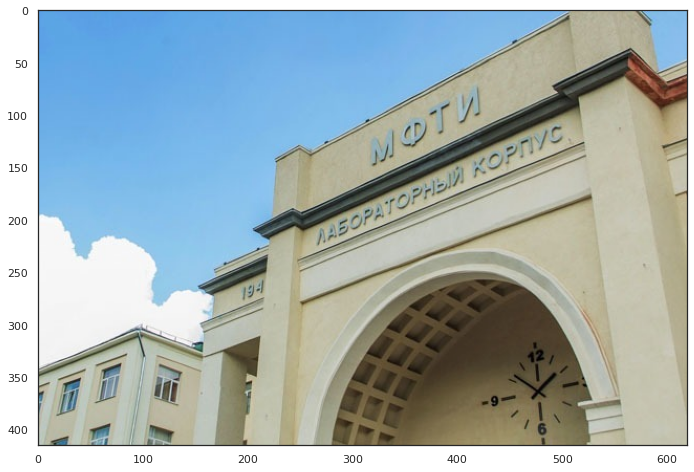

In [34]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Try to see how different convolutions affect the photo. For example try
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```


In [37]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


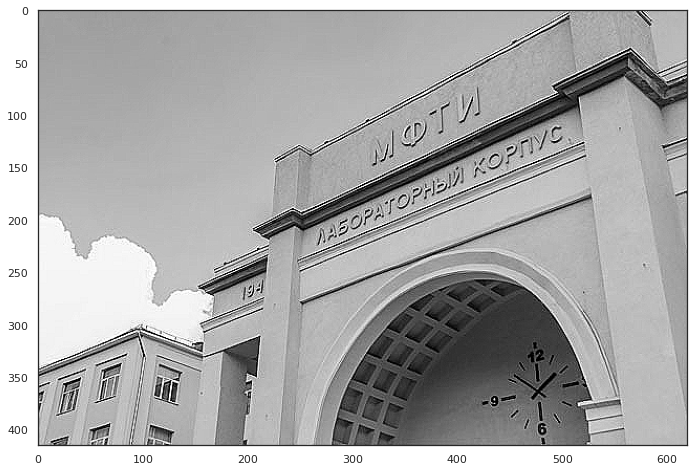

In [38]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

### Exercise. Implement LeNet

If we make convolution parameters trainable, we can achieve good results for computer vision problems. Implement the LeNet architecture proposed back in 1998!
This time, use a modular structure (without the help of the Sequential class).

Our neural network will consist of
* 3x3 convolutions (1 map in, 6 out) with ReLU activation;
* MaxPooling 2x2;
* 3x3 convolutions (6 maps in, 16 maps out) with ReLU activation;
* MaxPooling 2x2;
* Flattening (nn.Flatten);
* Fully connected layer with 120 neurons and ReLU activation;
* Fully connected layer with 84 neurons and ReLU activation;
* Output layer of 10 neurons.



In [53]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(self.fc1(x.flatten(1)))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [55]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Exercise. Train CNN
Use the training code you wrote for a fully connected neural network.

In [60]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        for x_batch, y_batch in dataloader:
            epoch_correct = 0
            epoch_all = 0

            if k == "train":
                 optimizer.zero_grad()
                 model.train()
                 outp = model(x_batch.to(device))                
            else:         
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch.to(device))
            
            preds = outp.argmax(-1)
            correct = (preds == y_batch.to(device)).sum()
            all =  preds.shape[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9479166666666666
Loader: valid. Accuracy: 0.9583333333333334
Epoch: 2
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 0.9895833333333334
Epoch: 3
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 0.9895833333333334
Epoch: 4
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 0.9791666666666666
Epoch: 5
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 0.9895833333333334
Epoch: 6
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 0.9895833333333334
Epoch: 7
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 0.9895833333333334
Epoch: 8
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 1.0
Epoch: 9
Loader: train. Accuracy: 1.0
Loader: valid. Accuracy: 1.0
Epoch: 10
Loader: train. Accuracy: 0.9895833333333334
Loader: valid. Accuracy: 0.9895833333333334


In [64]:
lenet_accuracy = accuracy["valid"][5:]
max_epochs = 5

Compare with the previous point

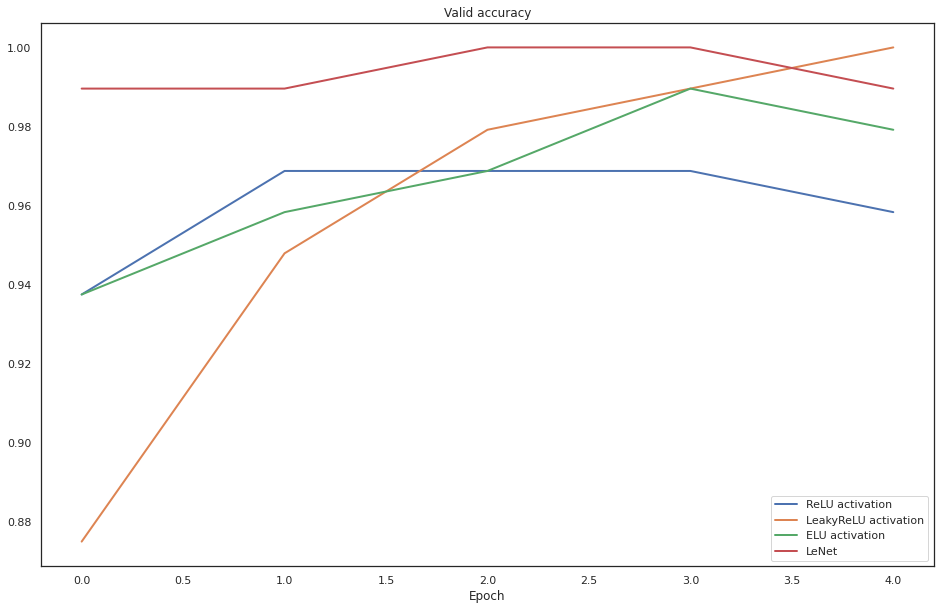

In [65]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy['valid'], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy['valid'], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy['valid'], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [66]:
lenet_accuracy[-1]

0.9895833333333334